##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with an LSTM

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
keras = tf.keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_excel("/content/drive/MyDrive/datasets/ORION_04_Site.xlsx", sheet_name="Training set")
validation = pd.read_excel("/content/drive/MyDrive/datasets/ORION_04_Site.xlsx", sheet_name="Validation set")

In [ ]:
train.head(12)

,Date,Site,Revenus,Pages vues,RPM
0,2020 - 04 - 01,business insider,3141.619208,503723,6.236799
1,2020 - 04 - 01,ca m'intéresse,436.874643,172725,2.529308
2,2020 - 04 - 01,capital,4984.707725,2512409,1.984035
3,2020 - 04 - 01,ce soir tv,306.073975,281211,1.088414
4,2020 - 04 - 01,cuisine actuelle,2261.649321,2579098,0.876915
5,2020 - 04 - 01,femme actuelle,5174.932616,3750732,1.379713
6,2020 - 04 - 01,gala,13277.638776,7560234,1.756247
7,2020 - 04 - 01,geo,448.199752,343632,1.304302
8,2020 - 04 - 01,harvard business,259.296636,79807,3.249046
9,2020 - 04 - 01,neon,310.103884,66552,4.659573


In [ ]:
sites = ["business insider", "ca m'intéresse", "capital", "ce soir tv", "cuisine actuelle",
         "femme actuelle", "gala", "geo", "neon", "télé 2 semaines", "télé loisirs", "voici"]

In [ ]:


# choose learning rate

for site in sites:
  print("TRAINING {}".format(site))
  x_train = train[train.Site == site]["RPM"]
  x_valid = validation[validation.Site == site]["RPM"]

  class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

  keras.backend.clear_session()
  tf.random.set_seed(42)
  np.random.seed(42)

  window_size = 7
  train_set = sequential_window_dataset(x_train, window_size)

  model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, stateful=True,
                      batch_input_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1)])
  
  lr_schedule = keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-6 * 10**(epoch / 20))
  reset_states = ResetStatesCallback()
  optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
  model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  history = model.fit(train_set, epochs=100,
                      callbacks=[lr_schedule, reset_states])
  print("\n")
  fig = plt.figure()
  plt.semilogx(history.history["lr"], history.history["loss"])
  plt.axis([1e-6, 1e-2, 0, 5])
  plt.xlabel("Learning rate")
  plt.ylabel("Validation loss")
  plt.title(site)
  plt.savefig(str(site) + "_2layers.png", format="png")
  fig.clear()
  plt.close(fig)

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    #plt.xticks(time[start:end], time[start:end], rotation='vertical')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
  
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

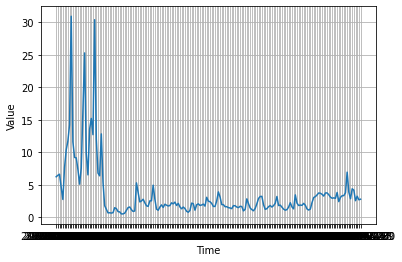

In [ ]:
x_train = train[train.Site == "business insider"]["RPM"]
time_train = train[train.Site == "business insider"]["Date"]
plot_series(time_train, x_train)

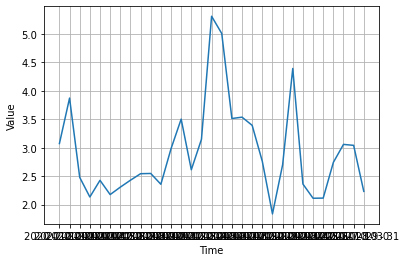

In [ ]:
x_valid = validation[validation.Site == "business insider"]["RPM"]
time_valid = validation[validation.Site == "business insider"]["Date"]
plot_series(time_valid, x_valid)

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
lr1 = [1e-4, 1e-5, 2*1e-5, 2*1e-5, 2*1e-5, 2*1e-5, 2*1e-5, 2*1e-5, 1e-4, 2*1e-5, 2*1e-5, 2*1e-5]
lr2 = [1e-4, 3*1e-5, 3*1e-5, 3*1e-5, 2*1e-5, 2*1e-5, 3*1e-5, 3*1e-5, 3*1e-5, 3*1e-5, 3*1e-5, 3*1e-5]

dict_lr1 = dict(zip(sites, lr1))
dict_lr2 = dict(zip(sites, lr2))

In [ ]:
# calculate mse on train data
def calculate_mse(true_values, forecast_values):
  return np.sum(np.square(true_values.values - forecast_values))/len(true_values)

# calculate aic on train data
def calculate_aic(n, mse, num_params):
  aic = n * np.log(mse) + 2 * num_params
  return aic

# calculate rmse on validation data
def calculate_rmse(true_values, forecast_values):
  return np.sqrt(np.sum(np.square(true_values.values - forecast_values))/31)

In [ ]:
# training loop for all sites

for site in sites:
  print("TRAINING {}".format(site))

  x_train = train[train.Site == site]["RPM"]
  x_valid = validation[validation.Site == site]["RPM"]


  keras.backend.clear_session()
  tf.random.set_seed(42)
  np.random.seed(42)

  window_size = 7
  train_set = sequential_window_dataset(x_train, window_size)
  valid_set = sequential_window_dataset(x_valid, window_size)

  model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, stateful=True,
                          batch_input_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1)
  ])
  optimizer = keras.optimizers.SGD(lr=dict_lr2[site], momentum=0.9)
  model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  reset_states = ResetStatesCallback()
  model_checkpoint = keras.callbacks.ModelCheckpoint(
      str(site) + "_checkpoint2.h5", save_best_only=True)
  early_stopping = keras.callbacks.EarlyStopping(patience=50)
  model.fit(train_set, epochs=500,
            validation_data=valid_set,
            callbacks=[early_stopping, model_checkpoint, reset_states])
  
  # load best model
  model = keras.models.load_model(str(site) + "_checkpoint2.h5")

  # forecast on train data
  train_forecast = model.predict(x_train[np.newaxis, :, np.newaxis])
  train_forecast = train_forecast[0, :, 0]

  # forecast on validation data
  rnn_forecast = model.predict(x_valid[np.newaxis, :, np.newaxis])
  rnn_forecast = rnn_forecast[0, :, 0]

  train_mse = calculate_mse(x_train, train_forecast)
  aic = calculate_aic(len(x_train), train_mse, model.count_params())
  rmse = calculate_rmse(x_valid, rnn_forecast)

  print("Number of parameters: {}".format(model.count_params()))
  print("AIC: {}".format(aic))
  print("RMSE: {}".format(rmse))

TRAINING business insider
Epoch 1/500
176/176 [==============================] - 4s 10ms/step - loss: 5.2929 - root_mean_squared_error: 8.5612 - val_loss: 1.0986 - val_root_mean_squared_error: 1.7967
Epoch 2/500
176/176 [==============================] - 1s 6ms/step - loss: 4.0230 - root_mean_squared_error: 7.3727 - val_loss: 0.3744 - val_root_mean_squared_error: 1.0083
Epoch 3/500
176/176 [==============================] - 1s 6ms/step - loss: 3.5774 - root_mean_squared_error: 6.7740 - val_loss: 0.2944 - val_root_mean_squared_error: 0.8715
Epoch 4/500
176/176 [==============================] - 1s 6ms/step - loss: 3.4311 - root_mean_squared_error: 6.5642 - val_loss: 0.2819 - val_root_mean_squared_error: 0.8421
Epoch 5/500
176/176 [==============================] - 1s 6ms/step - loss: 3.3251 - root_mean_squared_error: 6.4333 - val_loss: 0.2768 - val_root_mean_squared_error: 0.8273
Epoch 6/500
176/176 [==============================] - 1s 6ms/step - loss: 3.2223 - root_mean_squared_error:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Streaming output truncated to the last 5000 lines.
176/176 [==============================] - 1s 8ms/step - loss: 0.0288 - root_mean_squared_error: 0.2311 - val_loss: 0.0977 - val_root_mean_squared_error: 0.4429
Epoch 463/500
176/176 [==============================] - 1s 8ms/step - loss: 0.0288 - root_mean_squared_error: 0.2311 - val_loss: 0.0977 - val_root_mean_squared_error: 0.4429
Epoch 464/500
176/176 [==============================] - 1s 8ms/step - loss: 0.0288 - root_mean_squared_error: 0.2311 - val_loss: 0.0977 - val_root_mean_squared_error: 0.4429
Epoch 465/500
176/176 [==============================] - 1s 8ms/step - loss: 0.0288 - root_mean_squared_error: 0.2311 - val_loss: 0.0977 - val_root_mean_squared_error: 0.4428
Epoch 466/500
176/176 [==============================] - 1s 8ms/step - loss: 0.0288 - root_mean_squared_error: 0.2311 - val_loss: 0.0977 - val_root_mean_squared_error: 0.4428
Epoch 467/500
176/176 [==============================] - 1s 8ms/step - loss: 0.0288 - ro

## LSTM RNN Forecasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 7
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  #keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  #keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
176/176 [==============================] - 8s 4ms/step - loss: 5.2373 - root_mean_squared_error: 8.3692
Epoch 2/100
176/176 [==============================] - 1s 4ms/step - loss: 5.2157 - root_mean_squared_error: 8.3505
Epoch 3/100
176/176 [==============================] - 1s 3ms/step - loss: 5.1909 - root_mean_squared_error: 8.3291
Epoch 4/100
176/176 [==============================] - 1s 3ms/step - loss: 5.1632 - root_mean_squared_error: 8.3050
Epoch 5/100
176/176 [==============================] - 1s 4ms/step - loss: 5.1321 - root_mean_squared_error: 8.2780
Epoch 6/100
176/176 [==============================] - 1s 3ms/step - loss: 5.0971 - root_mean_squared_error: 8.2475
Epoch 7/100
176/176 [==============================] - 1s 4ms/step - loss: 5.0578 - root_mean_squared_error: 8.2132
Epoch 8/100
176/176 [==============================] - 1s 3ms/step - loss: 5.0136 - root_mean_squared_error: 8.1745
Epoch 9/100
176/176 [==============================] - 1s 3ms/step - los

Text(0.5, 1.0, 'business insider')

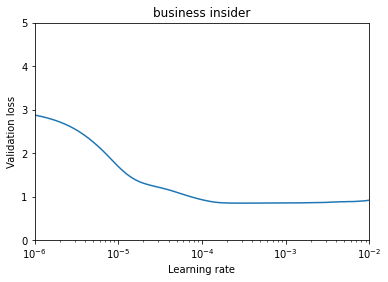

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-2, 0, 5])
plt.xlabel("Learning rate")
plt.ylabel("Validation loss")
plt.title("business insider")


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 7
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  #keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  #keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
176/176 [==============================] - 9s 8ms/step - loss: 4.8610 - root_mean_squared_error: 8.1723 - val_loss: 0.6213 - val_root_mean_squared_error: 1.3089
Epoch 2/500
176/176 [==============================] - 1s 4ms/step - loss: 3.5438 - root_mean_squared_error: 6.7946 - val_loss: 0.2805 - val_root_mean_squared_error: 0.8459
Epoch 3/500
176/176 [==============================] - 1s 4ms/step - loss: 3.1395 - root_mean_squared_error: 6.2523 - val_loss: 0.2610 - val_root_mean_squared_error: 0.7946
Epoch 4/500
176/176 [==============================] - 1s 4ms/step - loss: 2.9239 - root_mean_squared_error: 5.9769 - val_loss: 0.2590 - val_root_mean_squared_error: 0.7835
Epoch 5/500
176/176 [==============================] - 1s 4ms/step - loss: 2.7413 - root_mean_squared_error: 5.7503 - val_loss: 0.2594 - val_root_mean_squared_error: 0.7799
Epoch 6/500
176/176 [==============================] - 1s 4ms/step - loss: 2.5838 - root_mean_squared_error: 5.5464 - val_loss: 0.2606 

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
# forecast on train data
train_forecast = model.predict(x_train[np.newaxis, :, np.newaxis])
train_forecast = train_forecast[0, :, 0]

# forecast on validation data
rnn_forecast = model.predict(x_valid[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, :, 0]


# calculate mse on train data
def calculate_mse(true_values, forecast_values):
  return np.sum(np.square(true_values.values - forecast_values))/len(true_values)

# calculate aic on train data
def calculate_aic(n, mse, num_params):
  aic = n * np.log(mse) + 2 * num_params
  return aic

# calculate rmse on validation data
def calculate_rmse(true_values, forecast_values):
  return np.sqrt(np.sum(np.square(true_values.values - forecast_values))/31)

train_mse = calculate_mse(x_train, train_forecast)
aic = calculate_aic(len(x_train), train_mse, model.count_params())
rmse = calculate_rmse(x_valid, rnn_forecast)

print("Number of parameters: {}".format(model.count_params()))
print("AIC: {}".format(aic))
print("RMSE: {}".format(rmse))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


Number of parameters: 40901
AIC: 82272.00860149047
RMSE: 0.6468466698183002


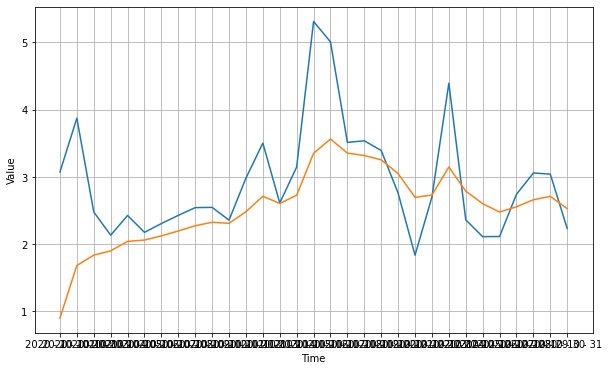

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)